
### 1. Data reading




First load and normalize our training and test data using `torchvision` .


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
from utils import show_examples, UnNormalize

In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),

    transforms.RandomCrop(32,padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
Batch_Size = 64

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=8)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



### 2. View data (format, size, shape)


In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape

(50000, 32, 32, 3)

In [8]:

print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>



### Summarize:

### 3. View pictures


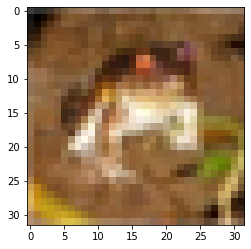

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

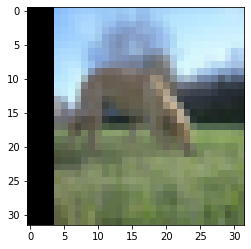

In [11]:
imshow(im[0])

In [12]:
im[0].shape

torch.Size([3, 32, 32])

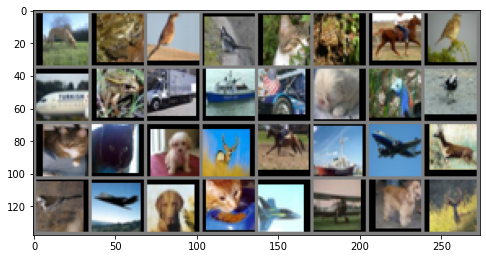

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
device

'cuda'

### BasicBlock

![在这里插入图片描述](https://img-blog.csdnimg.cn/dd6011dbb4b54988b4b0c30e473361b9.png)

In [15]:
class BasicBlock(nn.Module):
    """
    For shallow networks, such as ResNet-18/34, etc., use the basic Block
    The base module is not compressed, so expansion=1
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # If the input and output dimensions are not equal, use a 1x1 convolutional layer to change the dimension
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
    def forward(self, x):
        out = self.features(x)
# print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [16]:

basic_block = BasicBlock(64, 128)
print(basic_block)
x = torch.randn(2, 64, 32, 32)
y = basic_block(x)
print(y.shape)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 128, 32, 32])


In [17]:
class Bottleneck(nn.Module):
    """
    For deep networks, we use BottleNeck, which is proposed in the paper to have approximate computational complexity but save a lot of resources
    zip_channels: The compressed dimension, the final output dimension is expansion * zip_channels
    For the network structure of ResNet50/101/152, mainly because the third layer is 4 times the second layer, so expansion=4
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
# print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [18]:

bottleneck = Bottleneck(256, 128)
print(bottleneck)
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)
print(y.shape)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 512, 32, 32])


In [19]:
class ResNet(nn.Module):
    """
    Different ResNet architectures are unified with one layer of feature extraction and four layers of residuals, and the difference lies in the depth of each layer of residuals.
    For cifar10, the change of feature map size is as follows:
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2]
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool]
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=10, verbose = False):
        super(ResNet, self).__init__()
        self.verbose = verbose
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        #Use the _make_layer function to generate the structure of conv2_x, conv3_x, conv4_x, conv5_x corresponding to the above table
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # After cifar10 goes through the above structure, the feature map size here is 4 x 4 x 512 x expansion
        # So 4 x 4 average pooling is used here
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 *block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # The first block needs to be downsampled
        strides = [stride] + [1]* (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # If it is Bottleneck Block, you need to compress the input dimension of each layer, and then increase the dimension after compression
            # So the input dimension of each layer should also change accordingly
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        out = self.layer1(out)
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))
        out = self.layer2(out)
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))
        out = self.layer3(out)
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
        out = self.layer4(out)
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [20]:
def ResNet18(verbose=False):
    return ResNet(BasicBlock, [2,2,2,2],verbose=verbose)

def ResNet34(verbose=False):
    return ResNet(BasicBlock, [3,4,6,3],verbose=verbose)

def ResNet50(verbose=False):
    return ResNet(Bottleneck, [3,4,6,3],verbose=verbose)

def ResNet101(verbose=False):
    return ResNet(Bottleneck, [3,4,23,3],verbose=verbose)

def ResNet152(verbose=False):
    return ResNet(Bottleneck, [3,8,36,3],verbose=verbose)

net = ResNet18(True).to(device)

In [21]:
summary(net,(3,32,32))

block 1 output: torch.Size([2, 64, 32, 32])
block 2 output: torch.Size([2, 64, 32, 32])
block 3 output: torch.Size([2, 128, 16, 16])
block 4 output: torch.Size([2, 256, 8, 8])
block 5 output: torch.Size([2, 512, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchN

In [22]:
print(net)

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [23]:

x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

block 1 output: torch.Size([2, 64, 32, 32])
block 2 output: torch.Size([2, 64, 32, 32])
block 3 output: torch.Size([2, 128, 16, 16])
block 4 output: torch.Size([2, 256, 8, 8])
block 5 output: torch.Size([2, 512, 4, 4])
torch.Size([2, 10])


In [24]:
net = ResNet34().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True


### 5. Define the loss function and optimizer

 Pytorch encapsulates all the optimization methods commonly used in deep learning in torch.optim, and all optimization methods inherit the base class optim.Optimizier

 The loss function is encapsulated in the neural network toolbox nn, which contains many loss functions


In [25]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) 

import time
epoch = 50


### 6. Training


In [26]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/ResNet34.pth'

The file already exists


In [27]:
from utils import train
from utils import plot_history
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/ 50]  Train Loss:1.560865  Train Acc:42.97% Test Loss:1.299449  Test Acc:57.14%  Learning Rate:0.010000	Time 00:56
Epoch [  2/ 50]  Train Loss:1.023516  Train Acc:63.63% Test Loss:0.952111  Test Acc:67.83%  Learning Rate:0.010000	Time 00:55
Epoch [  3/ 50]  Train Loss:0.773039  Train Acc:73.12% Test Loss:0.784331  Test Acc:74.63%  Learning Rate:0.010000	Time 00:55
Epoch [  4/ 50]  Train Loss:0.649189  Train Acc:77.62% Test Loss:0.732273  Test Acc:75.02%  Learning Rate:0.010000	Time 00:55
Epoch [  5/ 50]  Train Loss:0.555409  Train Acc:81.00% Test Loss:0.627233  Test Acc:79.62%  Learning Rate:0.010000	Time 00:55
Epoch [  6/ 50]  Train Loss:0.497796  Train Acc:82.77% Test Loss:0.532121  Test Acc:82.10%  Learning Rate:0.010000	Time 00:55
Epoch [  7/ 50]  Train Loss:0.449644  Train Acc:84.51% Test Loss:0.510599  Test Acc:83.39%  Learning Rate:0.010000	Time 00:55
Epoch [  8/ 50]  Train Loss:0.412933  Train Acc:85.76% Test Loss:0.506993  Test Acc:83.77%  Learning Rate:0.010000	Tim

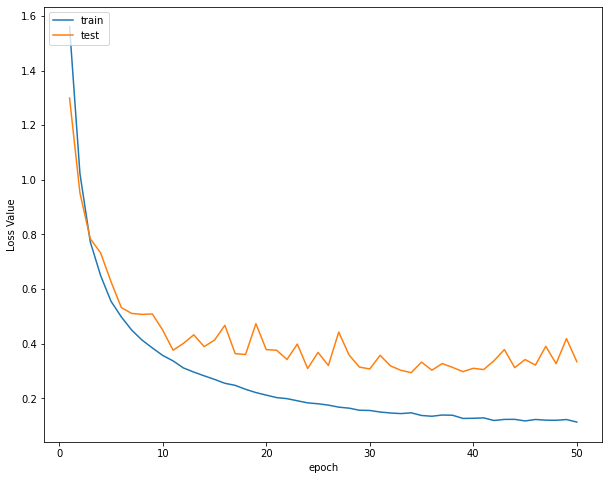

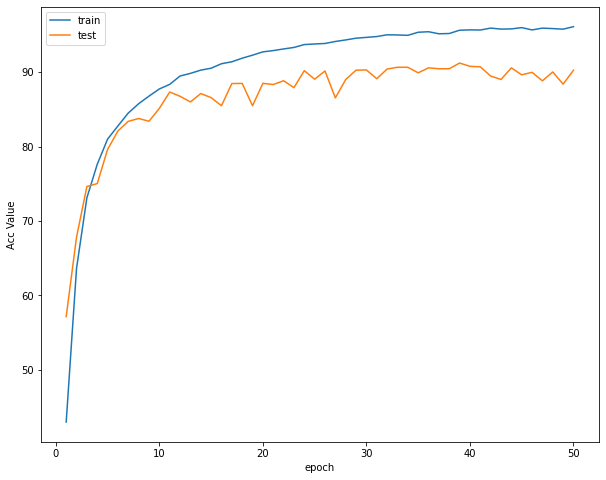

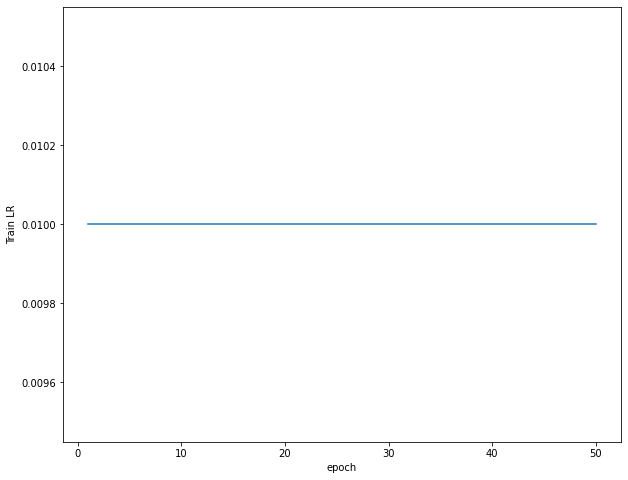

In [28]:
plot_history(epoch ,Acc, Loss, Lr)


### 7. Test


In [29]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 90.21 %


In [30]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 90.40 %
Accuracy of automobile : 95.00 %
Accuracy of  bird : 83.20 %
Accuracy of   cat : 88.00 %
Accuracy of  deer : 90.40 %
Accuracy of   dog : 71.50 %
Accuracy of  frog : 94.20 %
Accuracy of horse : 96.00 %
Accuracy of  ship : 96.40 %
Accuracy of truck : 97.00 %


Accuracy Rate = 90.625%


<Figure size 1800x288 with 0 Axes>

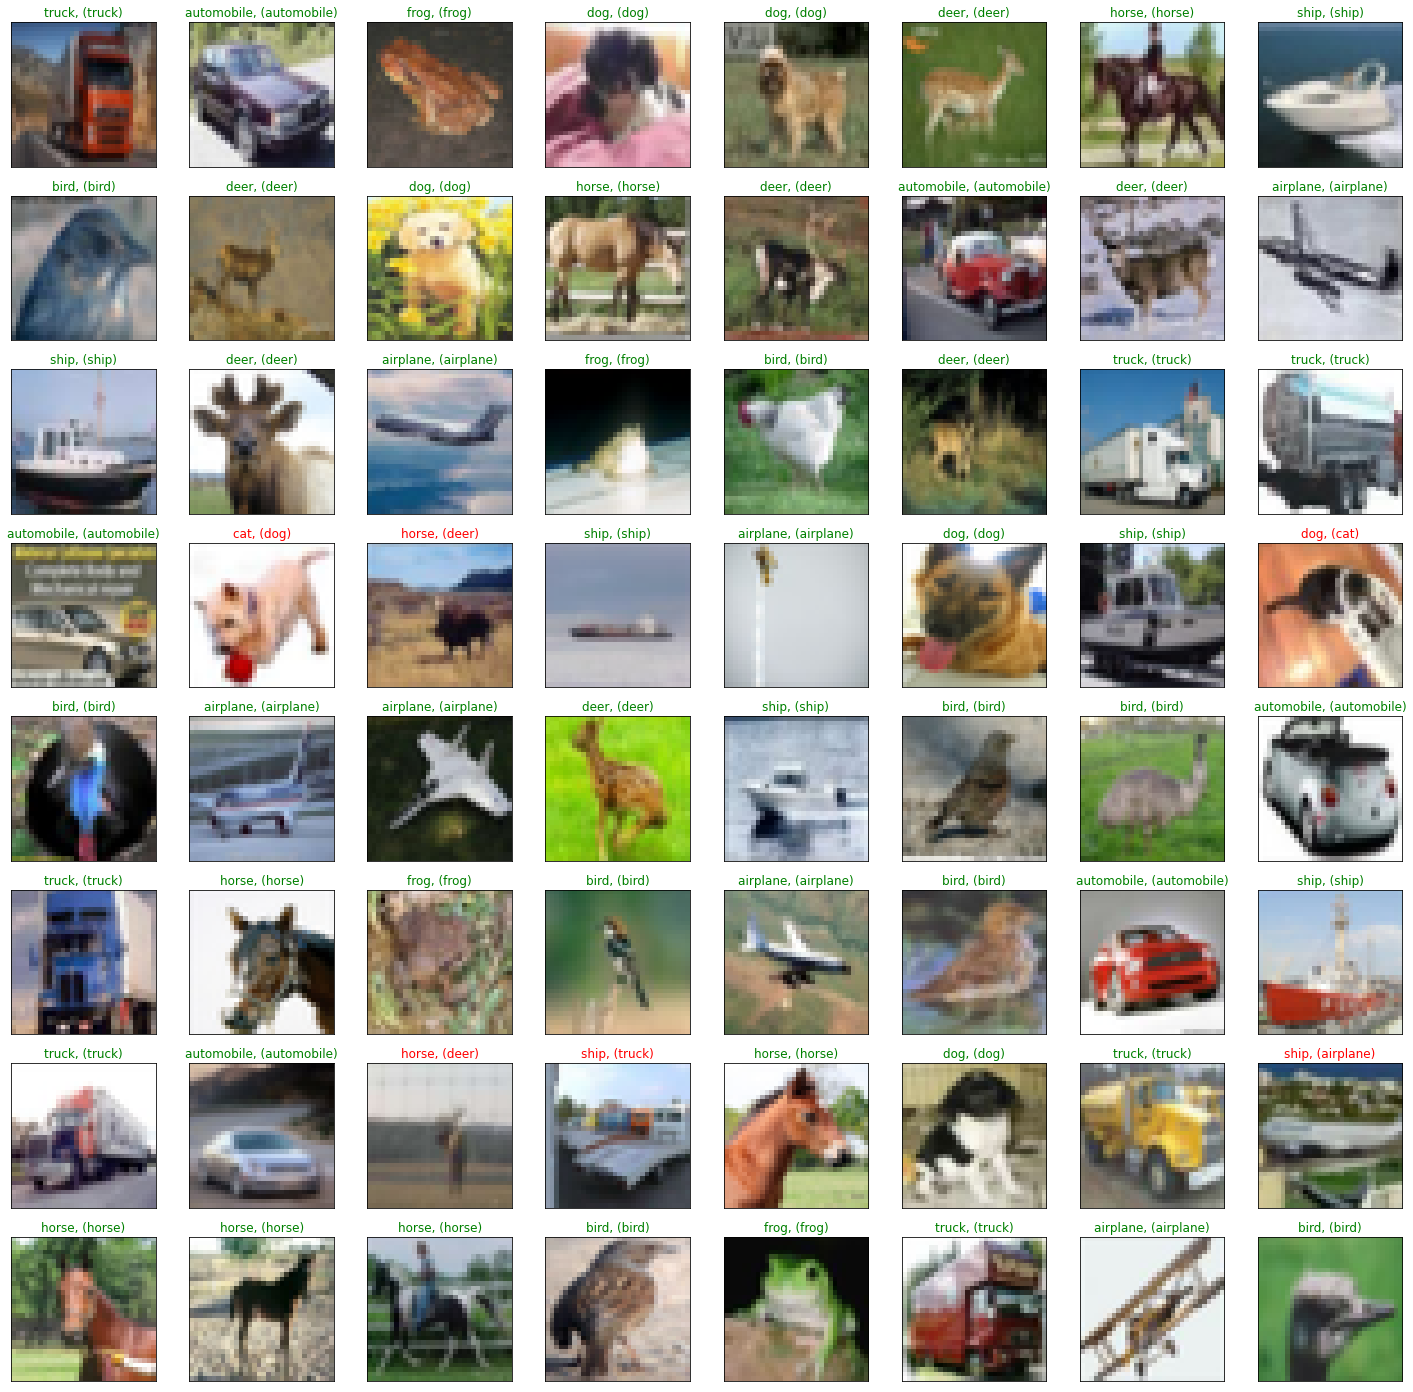

In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

# val_preds = val_preds.cpu()
# labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

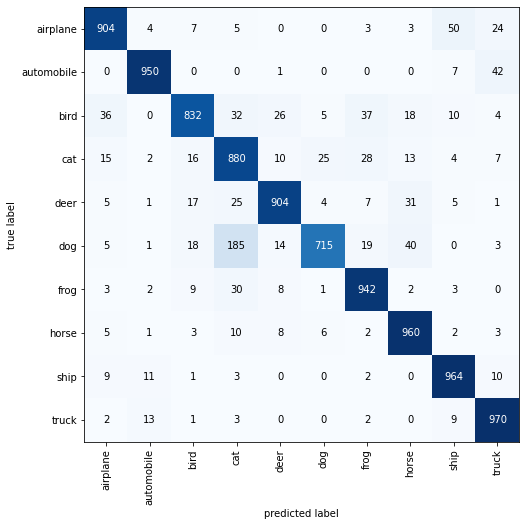

In [32]:
from utils import compute_confusion_matrix
from utils import plot_confusion_matrix

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()


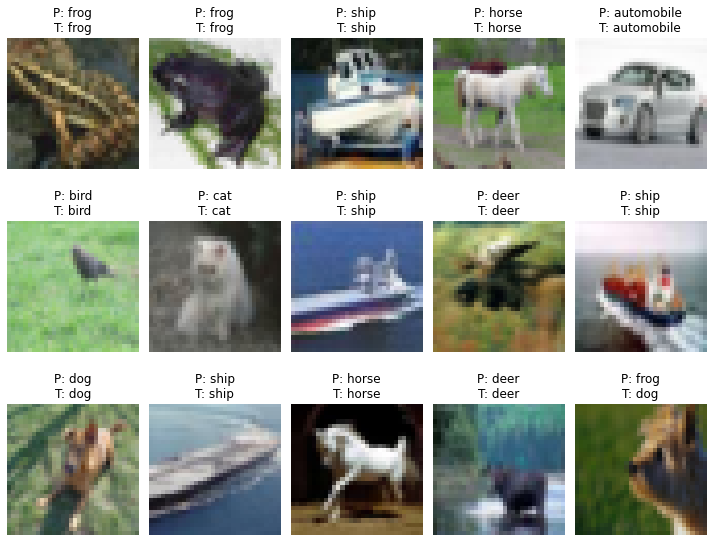

In [33]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

In [34]:
Acc

{'train_acc': [42.9747428894043,
  63.634910583496094,
  73.11580657958984,
  77.61548614501953,
  81.00423431396484,
  82.7745361328125,
  84.50887298583984,
  85.75567626953125,
  86.78069305419922,
  87.7397689819336,
  88.35917663574219,
  89.48209381103516,
  89.83375549316406,
  90.2713394165039,
  90.52709197998047,
  91.13251495361328,
  91.39026641845703,
  91.87580108642578,
  92.28141021728516,
  92.72498321533203,
  92.89682006835938,
  93.11660766601562,
  93.3204116821289,
  93.70603942871094,
  93.78596496582031,
  93.85189819335938,
  94.12164306640625,
  94.3294448852539,
  94.56521606445312,
  94.67311096191406,
  94.78500366210938,
  95.02078247070312,
  94.9968032836914,
  94.94884490966797,
  95.3624496459961,
  95.43238067626953,
  95.15464782714844,
  95.19261169433594,
  95.63419342041016,
  95.68014526367188,
  95.66216278076172,
  95.91991424560547,
  95.78604125976562,
  95.81002044677734,
  95.98585510253906,
  95.6761474609375,
  95.9159164428711,
  95.8559


### 8. Save the model


In [35]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')
# torch.save(net, './model/ResNet34.pth')